# Quick conv1d exploration

TODO: get back to this at some point to see if we can build and train a more accurate conv model

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import callbacks
from matplotlib import pyplot as plt
from pathlib import Path
from functools import partial
try:
    from utils.plot_history import *
except ModuleNotFoundError:
    if not Path('plot_history.py').is_file():
        !wget https://raw.githubusercontent.com/pete88b/deep_learning_with_python/main/utils/plot_history.py
    from plot_history import *

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-ulm0i11w because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
Path('data/models').mkdir(exist_ok=True, parents=True)
if not Path('jena_climate_2009_2016.csv.zip').is_file():
    !wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
    !unzip jena_climate_2009_2016.csv.zip -d data
with open("data/jena_climate_2009_2016.csv") as f:
    data = f.read()
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(len(header), 'features', len(lines), 'rows of data')
print(header)

15 features 420451 rows of data
['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']


In [3]:
lines[0]

'01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30'

# Convert data to np

In [4]:
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:] # features inc. temp

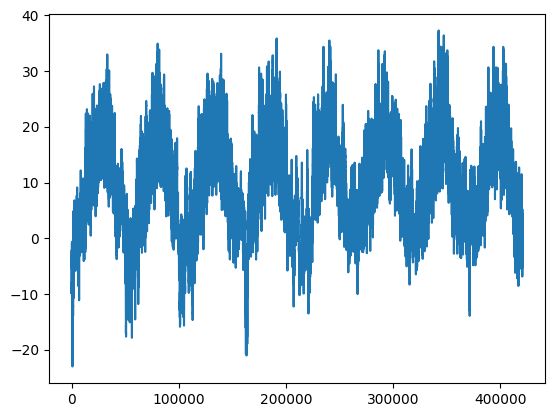

In [5]:
plt.plot(range(len(temperature)), temperature)
plt.show()

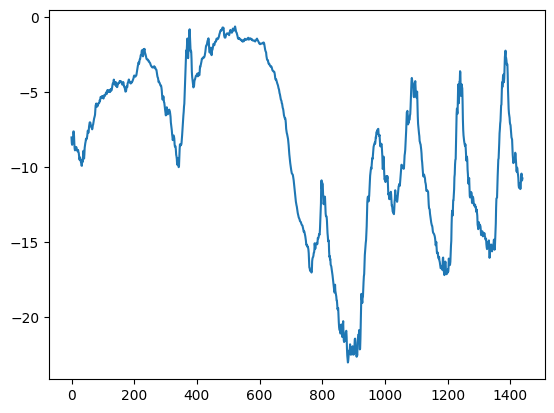

In [6]:
plt.plot(range(1440), temperature[:1440])
plt.show()

# Work out how many samples will be in each dataset

In [7]:
n_train_samples = len(temperature) // 2
n_val_samples = len(temperature) // 4
n_test_samples = len(temperature) - n_train_samples-n_val_samples
n_train_samples, n_val_samples, n_test_samples

(210225, 105112, 105114)

# Normalize data using train stats

In [8]:
mean = raw_data[:n_train_samples].mean(axis=0)
std = raw_data[:n_train_samples].std(axis=0)
raw_data -= mean
raw_data /= std

# Quick look at the normalized data

In [9]:
raw_data[:n_train_samples].min(axis=0), raw_data[:n_train_samples].max(axis=0)

(array([-8.83578303, -3.6296845 , -3.64386561, -4.14164583, -3.78396719,
        -1.60442381, -2.02660981, -0.82847061, -2.01707768, -2.02445711,
        -3.78222606, -1.40179408, -1.53267098, -2.055211  ]),
 array([2.83249825, 3.0822195 , 3.04828935, 2.29751734, 1.45093305,
        6.03506343, 3.63786658, 8.00243978, 3.67653916, 3.65929764,
        4.16486633, 8.13792568, 8.5833148 , 2.13813385]))

# Augmentation function

this just changes features (but not "T (degC)") by a little bit - all samples in a batch get the same adjustment

In [10]:
@tf.function
def augment_input(x):
    aug_mask = tf.random.normal([14,], stddev=0.5, dtype=tf.dtypes.float64)
    aug_mask = aug_mask * [1,0,1,1,1,1,1,1,1,1,1,1,1,1] # leave "T (degC)" alone
    return x + aug_mask

# Create datasets

In [11]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256
def new_dataset(start_index, end_index):
    dataset = keras.utils.timeseries_dataset_from_array(
            raw_data[:-delay],
            targets=temperature[delay:],
            sampling_rate=sampling_rate,
            sequence_length=sequence_length,
            shuffle=start_index == 0, # only shuffle train
            batch_size=batch_size,
            start_index=start_index,
            end_index=end_index)
    return dataset.prefetch(tf.data.AUTOTUNE)
train_dataset = new_dataset(0, n_train_samples)
train_dataset_augment = train_dataset.map(
        lambda x,y: (augment_input(x), y), num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = new_dataset(n_train_samples, n_train_samples + n_val_samples)
test_dataset = new_dataset(n_train_samples+n_val_samples, None)

In [12]:
for xb,yb in test_dataset:
    print(xb.shape, yb.shape, tf.reduce_mean(xb))
    break

(256, 120, 14) (256,) tf.Tensor(-0.16506525973728933, shape=(), dtype=float64)


In [13]:
xb[0][1] # input features for 1 timestep

<tf.Tensor: shape=(14,), dtype=float64, numpy=
array([ 0.84428144, -1.0997516 , -1.15559764, -1.15581759,  0.23015792,
       -0.9729525 , -1.11267343, -0.58316754, -1.11688609, -1.11962811,
        1.26709988,  1.15430308,  1.34715646,  1.00476592])>

# Common-sense, non-machine learning baseline

```
Naive validation MAE 2.4417357485655167
Naive test MAE 2.621898451761206

```

# Functions to build and train a model

In [14]:
@tf.function
def sigmoid_range(x):
    "Force output to be between -25 and 40"
    return keras.activations.sigmoid(x) * 65.0 - 25.0
# @tf.function
# def sigmoid_range(x, low, high):
#     "Force output to be between low and high"
#     return keras.activations.sigmoid(x) * (high - low) + low

In [15]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 conv1d (Conv1D)             (None, 97, 8)             2696      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 48, 8)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 37, 8)             776       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 18, 8)            0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 13, 8)             392   

In [16]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(filters=64, kernel_size=24, strides=24, activation="relu")(inputs)
x = layers.Conv1D(filters=64, kernel_size=5, strides=5, activation="relu")(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 conv1d_4 (Conv1D)           (None, 24, 64)            4544      
                                                                 
 dense_1 (Dense)             (None, 24, 1)             65        
                                                                 
Total params: 4,609
Trainable params: 4,609
Non-trainable params: 0
_________________________________________________________________


In [17]:
inputs = layers.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
inputs, x

(<KerasTensor: shape=(None, 120, 14) dtype=float32 (created by layer 'input_3')>,
 <KerasTensor: shape=(None, 1680) dtype=float32 (created by layer 'flatten')>)

In [18]:
conv1 = layers.Conv1D(filters=64, kernel_size=24, strides=24)(inputs)
conv1

<KerasTensor: shape=(None, 5, 64) dtype=float32 (created by layer 'conv1d_5')>

In [19]:
conv2 = layers.Conv1D(filters=64, kernel_size=5, strides=5)(conv1)
conv2

<KerasTensor: shape=(None, 1, 64) dtype=float32 (created by layer 'conv1d_6')>

In [20]:
def new_model(temporal_weight_range=None, l2_factor=None, dropout_rate=None, 
              final_activation=None, fit_residual=False):
    inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
    x = layers.Conv1D(filters=32, kernel_size=(3,), activation="relu")(inputs)
    x = layers.Dense(units=32, activation='relu')(x)
    outputs = layers.Dense(1)(x)
    return keras.Model(inputs, outputs)

#     inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
#     x = layers.Conv1D(filters=64, kernel_size=24, strides=24, activation="relu")(inputs)
#     x = layers.Conv1D(filters=64, kernel_size=5, strides=5, activation="relu")(inputs)
#     outputs = layers.Dense(1)(x)
#     model = keras.Model(inputs, outputs)
#     return model

#     inputs = layers.Input(shape=(sequence_length, raw_data.shape[-1]))
#     if temporal_weight_range is not None:
#         temporal_weight_mask = tf.linspace(temporal_weight_range[0], temporal_weight_range[1], 120)
#         x = layers.Flatten()(inputs * tf.expand_dims(temporal_weight_mask, -1))
#     else:
#         x = layers.Flatten()(inputs)
#     kernel_regularizer = None if l2_factor is None else regularizers.l2(l2_factor) 
#     x = layers.Dense(16, activation='relu', kernel_regularizer=kernel_regularizer)(x)
#     if dropout_rate is not None:
#         x = layers.Dropout(dropout_rate)(x)
#     x = layers.Dense(1, activation=final_activation)(x)
#     if fit_residual:
#         x = tf.expand_dims(inputs[:, -1, 1] * std[1] + mean[1], -1) + x
#     return keras.Model(inputs, x)

In [21]:
def compile_and_fit(model, model_tag, augment=False):
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    kwargs = dict(monitor='val_mae', verbose=1)
    cbs = [callbacks.ModelCheckpoint(f'data/models/jena_dense_{model_tag}.keras', 
                                     save_best_only=True, **kwargs),
           callbacks.EarlyStopping(patience=3, **kwargs)]
    history = model.fit(train_dataset_augment if augment else train_dataset,
                        epochs=5,
                        validation_data=val_dataset,
                        callbacks=cbs)
    del history.history['loss'] # we'll just plot mae
    plot_history(history, ignore_first_n=0)

In [22]:
def evaluate_model(model_tag):
    model = keras.models.load_model(f'data/models/jena_dense_{model_tag}.keras', 
                                    custom_objects=dict(sigmoid_range=sigmoid_range))
    print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f} for model tag: {model_tag}")

# Start with the best model we have &darr; 

Note: we don't use augmentation by default

In [25]:
CONV_WIDTH = 3
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

Epoch 1/5
810/819 [============================>.] - ETA: 0s - loss: 79.6568 - mae: 7.2209
Epoch 1: val_mae improved from inf to 6.61794, saving model to data/models/jena_dense_0.keras
819/819 [==============================] - 9s 10ms/step - loss: 79.6364 - mae: 7.2193 - val_loss: 64.6814 - val_mae: 6.6179
Epoch 2/5
811/819 [============================>.] - ETA: 0s - loss: 76.3125 - mae: 7.0782
Epoch 2: val_mae did not improve from 6.61794
819/819 [==============================] - 9s 10ms/step - loss: 76.2833 - mae: 7.0767 - val_loss: 65.2987 - val_mae: 6.6524
Epoch 3/5
814/819 [============================>.] - ETA: 0s - loss: 76.2483 - mae: 7.0750
Epoch 3: val_mae did not improve from 6.61794
819/819 [==============================] - 9s 11ms/step - loss: 76.2683 - mae: 7.0760 - val_loss: 66.4167 - val_mae: 6.7124
Epoch 4/5
814/819 [============================>.] - ETA: 0s - loss: 76.2348 - mae: 7.0747
Epoch 4: val_mae did not improve from 6.61794
819/819 [=======================

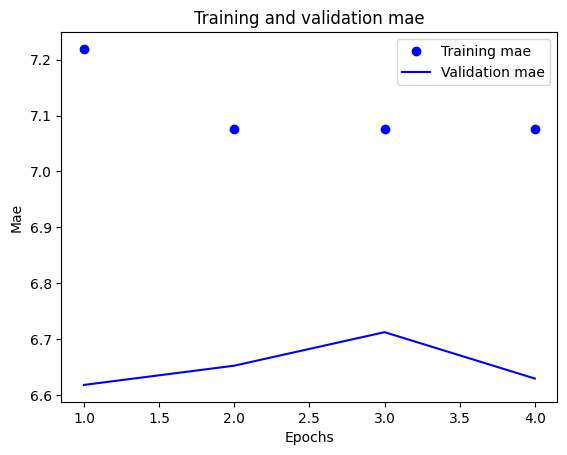

In [26]:
compile_and_fit(conv_model, 0)

Epoch 1/5
819/819 [==============================] - ETA: 0s - loss: 79.0032 - mae: 7.1921
Epoch 1: val_mae improved from inf to 6.56239, saving model to data/models/jena_dense_0.keras
819/819 [==============================] - 11s 11ms/step - loss: 79.0032 - mae: 7.1921 - val_loss: 63.8237 - val_mae: 6.5624
Epoch 2/5
810/819 [============================>.] - ETA: 0s - loss: 76.2930 - mae: 7.0778
Epoch 2: val_mae did not improve from 6.56239
819/819 [==============================] - 9s 10ms/step - loss: 76.2893 - mae: 7.0775 - val_loss: 66.7147 - val_mae: 6.7184
Epoch 3/5
814/819 [============================>.] - ETA: 0s - loss: 76.2506 - mae: 7.0754
Epoch 3: val_mae did not improve from 6.56239
819/819 [==============================] - 9s 11ms/step - loss: 76.2707 - mae: 7.0764 - val_loss: 66.3246 - val_mae: 6.6943
Epoch 4/5
810/819 [============================>.] - ETA: 0s - loss: 76.2353 - mae: 7.0746
Epoch 4: val_mae did not improve from 6.56239
819/819 [======================

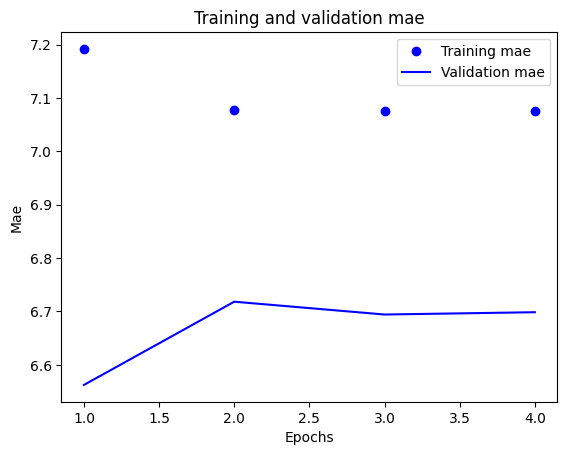

In [23]:
model = new_model(temporal_weight_range=[0.0, 2.0], l2_factor=1e-2, dropout_rate=0.5, 
                  final_activation=None, fit_residual=True)
compile_and_fit(model, 0)

In [ ]:
evaluate_model(0)

&uarr; 2.62 was the test MAE for the common-sense model, 2.45 was the test MAE for the LSTM with dropout, Stacked LSTM was 2.39